# Race-Memory Project Analysis Pipeline (v1)

Load libraries, custom functions, and data

In [2233]:
import math
import numpy as np
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import json
import scipy.stats as sp
import sklearn as sk
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from ast import literal_eval
from IPython.display import Markdown as md
import re, os
data_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/main/'
pd.options.mode.chained_assignment = None 
import warnings ; warnings.filterwarnings('ignore')

In [2234]:
# import custom functions
import functions as fun
meta = fun.load_metadata() # just in case

In [2235]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2357]:
# load data
files = [i for i in os.listdir(data_path) if i.startswith('taskdata')]
df_list = []
for f in files:
    if f != 'taskdata_chris_main_task_2_prolific_afc3_20_05_2022.csv':
        df_list.append(pd.read_csv(data_path + f))
df = pd.concat(df_list)

df2 = pd.read_csv(data_path + 'taskdata_chris_main_task_2_prolific_afc3_20_05_2022.csv')
w = df2[(df2.trial_type == 'demographics') & (df2.race.str.contains('White'))].experiment_id.to_numpy()
b = df2[(df2.trial_type == 'demographics') & (df2.race.str.contains('Black'))].experiment_id.to_numpy()
df = pd.concat([df, df2[df2.experiment_id.isin(w)]])

In [2358]:
# fill in tilt_difference and tilt_change
for i in range(len(df)):
    if 'retrieval' in df.trial_type.iloc[i]:
        if pd.isna(df.tilt_difference.iloc[i]) and not pd.isna(df.old_tiltLR.iloc[i]) and not pd.isna(df.old_original_tiltLR.iloc[i]):
            tilt = fun.get_tilt_change(df.old_original_tiltLR.iloc[i], df.old_tiltLR.iloc[i])
            df['tilt_difference'].iloc[i] = tilt['difference']
            df['tilt_change'].iloc[i] = tilt['change']  

In [2359]:
df['tilted'] = (df['tilt_difference'] != 0) & ( (df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice') )  
df.loc[(df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice'), 
       'response'] = pd.to_numeric(df.loc[(df['trial_type'] == 'retrieval') | 
                                          (df['trial_type'] == 'retrieval_practice'), 
                                          'response'])

In [2360]:
## PROLIFIC IDS THAT CONFIRMED HAD GLITCH
exclude = [
    '5e68682ce3b2f71041fa03d2', 
    '610d170f7bb4e720cb85b6b2',
    '580bea98827ca10001db514e',
    '60ba71aa8f2ae12d3a595982'
]
df = df[~df.subject_id.isin(exclude)]
print('EXPERIMENT IDS EXCLUDED:', '\n', exclude)

EXPERIMENT IDS EXCLUDED: 
 ['5e68682ce3b2f71041fa03d2', '610d170f7bb4e720cb85b6b2', '580bea98827ca10001db514e', '60ba71aa8f2ae12d3a595982']


In [2361]:
# exclude nan experiment id
df = df[~pd.isna(df.experiment_id)]

In [2362]:
# exclude subjects who didn't finish the experiment
df = fun.exclude_nofinish(df) 
# there are many because this contains data from a failed iteration 

EXPERIMENT IDS EXCLUDED:
 ['cqbz7lh19r6krarwzy7n', 'o1qhbw4lrfpx8jk9vyxn', 'y9krtso6fmwtl2u13csl', 'e79drsrtw4392byd7eem', '184gl7o42b9bdl9e6xsm', 'xpyxc6uu5ea54nd1fu5p', '4mc72sfz921j7s6hgvkm', 'urxm6qqdbsataccvjjcm', 'socq4e5100dn03j66xdr', 'f4qdjdd8mr5gm6djqcn9', 'coar15q7qjjbfusnr6yb']


In [2363]:
# also, exclude subjects who show terrible performance: wrong on a practice 5 times in a row
df = fun.exclude_practice(df, max_wrong = 5)
# also, exclude subjects who timed out on everything
df = fun.exclude_timeout(df)

EXPERIMENT IDS EXCLUDED:
 []
EXPERIMENT IDS EXCLUDED:
 ['g51c2p98lpbc8zxstqra', 'akn81dwp3vhwnstj0wmb']


In [2377]:
just_white_subjects = True
if just_white_subjects:
    old_df = df.copy()
    df_white = df[df.experiment_id.isin(
        df[df.race == "['White']"].experiment_id.unique()
    )]

print(len(old_df.experiment_id.unique()))
print(len(df_white.experiment_id.unique()))

113
55


In [2365]:
# exclude subjects by retrieval performance
# df = fun.exclude_chance_retrieval(df)

In [2366]:
print('# of participants remaining:')
print(len(df.experiment_id.unique()))

# of participants remaining:
113


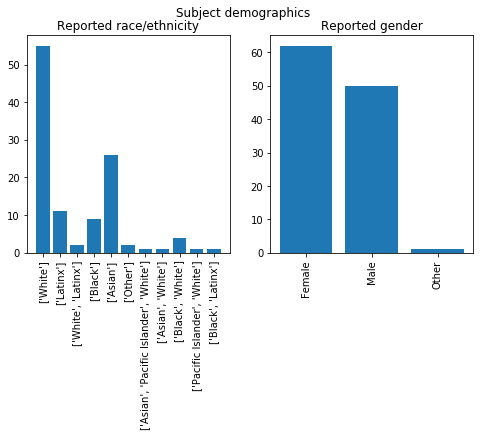

62 women, 50 men


In [2367]:
fun.demographics_plot(df)

In [2368]:
print('Age range: ' + str(df.age.min()) + " - " + str(df.age.max()))
print('Median age: ' + str(df.age.median()))

Age range: 18.0 - 63.0
Median age: 23.0


## Subject-Level Analysis

summary - encoding, filler, and retrieval accuracy and RT

In [2249]:
stats = fun.get_stats(df, only_correct_encoding = True)


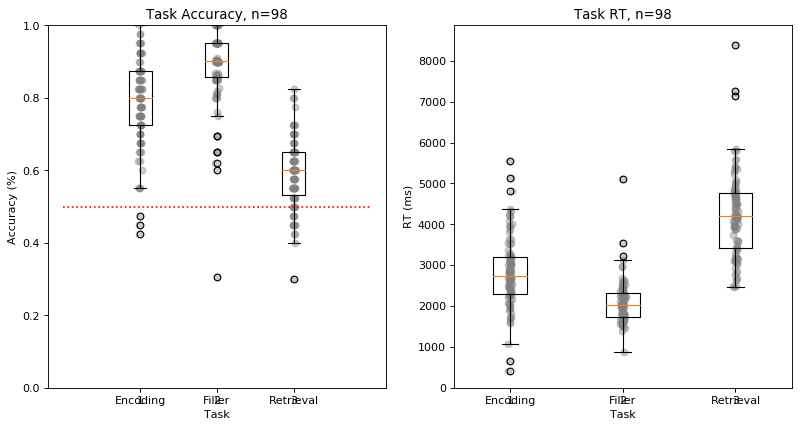

In [2250]:
fun.summary_plot(stats)

is retrieval performance significantly above chance?

In [2251]:
print(sp.ttest_1samp(stats.ret_acc, popmean = 0.5))

Ttest_1sampResult(statistic=9.759164058674697, pvalue=4.440696917693742e-16)


### 1. Encoding

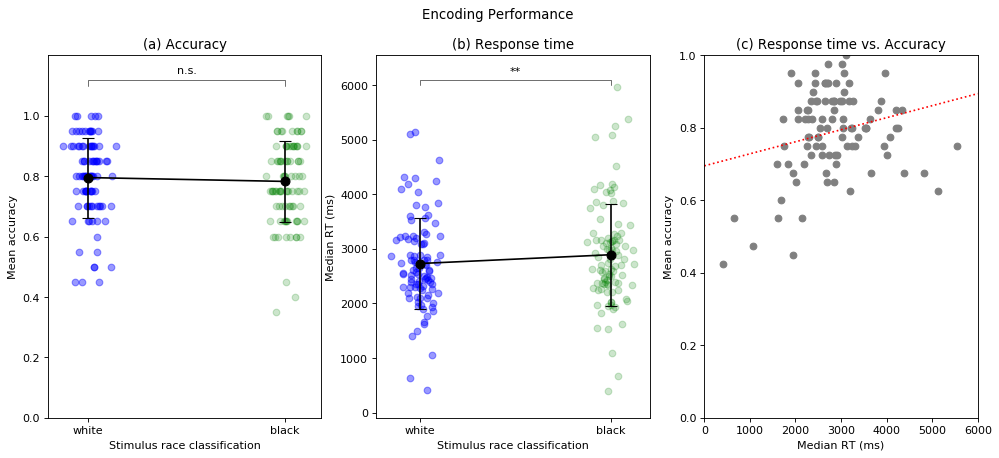

In [2252]:
fun.encoding_plot(stats, save=True)

In [2253]:
print(sp.wilcoxon(stats.enc_acc_delta))
print(sp.wilcoxon(stats.enc_rt_delta))

WilcoxonResult(statistic=1652.5, pvalue=0.3464941090451378)
WilcoxonResult(statistic=1575.0, pvalue=0.003926721366645497)


accuracy and RT by race 

In [2254]:
sp.linregress(x=stats.enc_rt, y=stats.enc_acc)

LinregressResult(slope=3.321868693046201e-05, intercept=0.6951883301156324, rvalue=0.24437007372576036, pvalue=0.015308906629843166, stderr=1.3453279935868632e-05)

In [2255]:
smf.ols('enc_acc ~ enc_rt', data = stats).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                enc_acc   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     6.097
Date:                Sat, 21 May 2022   Prob (F-statistic):             0.0153
Time:                        01:53:52   Log-Likelihood:                 75.064
No. Observations:                  98   AIC:                            -146.1
Df Residuals:                      96   BIC:                            -141.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6952      0.040     17.510      0.000       0.616       0.774
enc_rt      3.322e-05   1.35e-05      2.469      0.015    6.51e-06    5.99e-05
==============================================================================
Omnibus:                        4.044   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.971
Skew:                          -0.488   Prob(JB):                        0.137
Kurtosis:                       2.856   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Encoding performance by tilt metrics

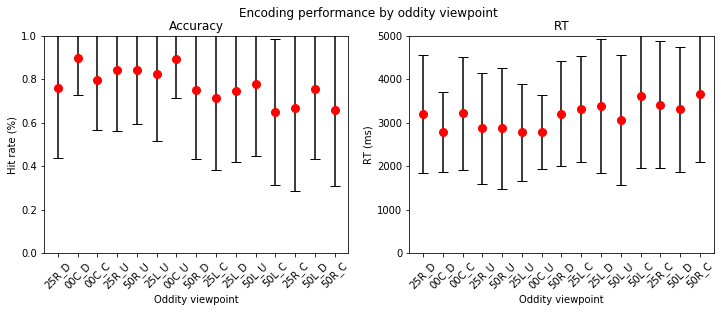

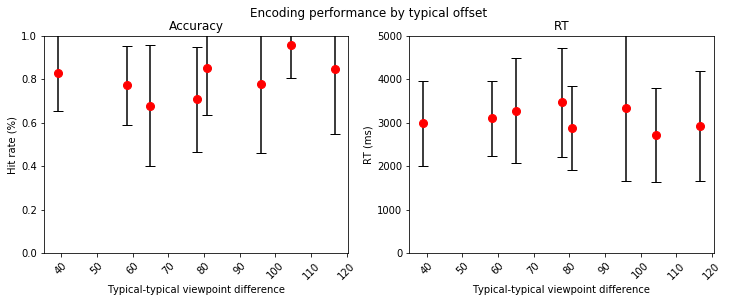

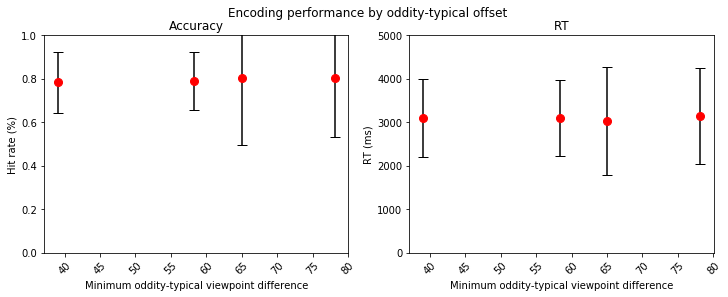

In [2256]:
fun.encoding_view_plots(df)

### 2. Filler

accuracy and RT by category

In [2257]:
stats.fil_acc.mean()

0.8924423919765535

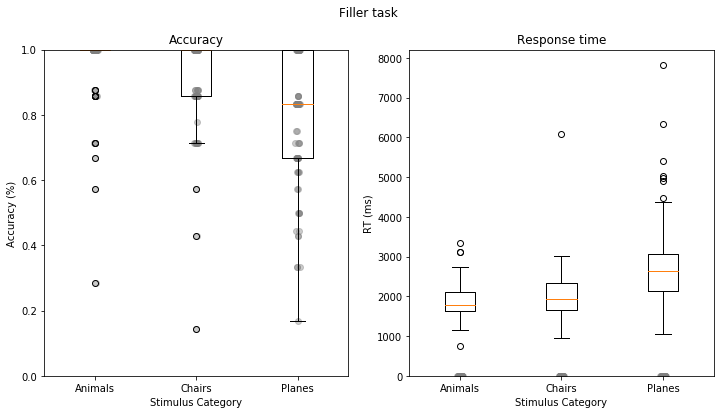

In [2258]:
fun.filler_plot(stats)

encoding-retrieval delay vs. mean retrieval accuracy per subject

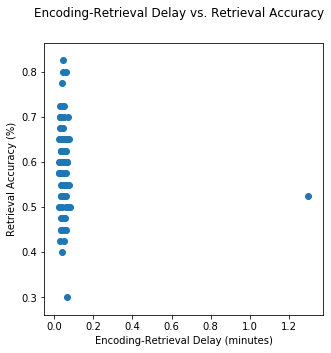

In [2259]:
fun.filler_delay_plot(stats)

In [2260]:
sp.linregress(x=stats.enc_ret_delay, y=stats.ret_acc)

LinregressResult(slope=-0.0009940098640284227, intercept=0.5932815458140138, rvalue=-0.08327768812219288, pvalue=0.41493101082289063, stderr=0.0012139903019684048)

Filler performance predicted by encoding performance

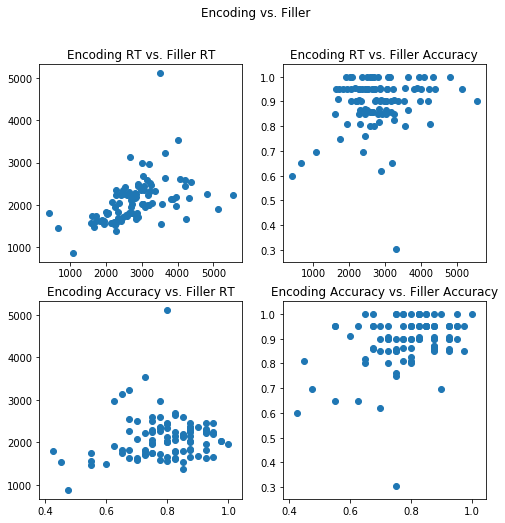

In [2261]:
fun.encoding_filler_plot(stats)

In [2262]:
print(sp.linregress(x=stats.enc_rt, y=stats.fil_rt))
print(sp.linregress(x=stats.enc_rt, y=stats.fil_acc))
print(sp.linregress(x=stats.enc_acc, y=stats.fil_rt))
print(sp.linregress(x=stats.enc_acc, y=stats.fil_acc))

LinregressResult(slope=0.28013783058513253, intercept=1310.2016511148158, rvalue=0.45615281225343907, pvalue=2.3544231085560994e-06, stderr=0.05577861264934961)
LinregressResult(slope=2.796468084328705e-05, intercept=0.8134425966250969, rvalue=0.22468590465631744, pvalue=0.026130967797706385, stderr=1.2377975584121446e-05)
LinregressResult(slope=639.4143902356465, intercept=1597.0692068880476, rvalue=0.14153226058498986, pvalue=0.1644895415030092, stderr=456.45443435762553)
LinregressResult(slope=0.326634897103286, intercept=0.6347174591345985, rvalue=0.35674918137626876, pvalue=0.0003112794635460547, stderr=0.08729792847620164)


In [2263]:
smf.ols('ret_acc ~ enc_ret_delay', data = stats).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ret_acc   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6704
Date:                Sat, 21 May 2022   Prob (F-statistic):              0.415
Time:                        01:54:10   Log-Likelihood:                 96.590
No. Observations:                  98   AIC:                            -189.2
Df Residuals:                      96   BIC:                            -184.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5933      0.010     58.437      0.000       0.573       0.613
enc_ret_delay    -0.0010      0.001     -0.819      0.415      -0.003       0.001
==============================================================================
Omnibus:                        2.074   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.354   Jarque-Bera (JB):                1.593
Skew:                          -0.107   Prob(JB):                        0.451
Kurtosis:                       3.587   Cond. No.                         9.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3. Retrieval

Serial position at encoding vs. average retrieval accuracy (for recency/primacy effects?)

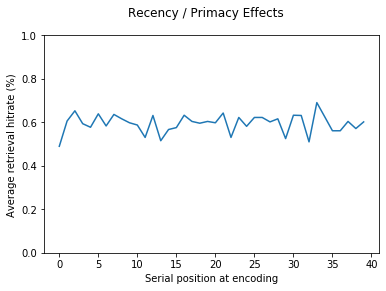

In [2264]:
# serial position
fun.serial_position_plot(df)

Distribution of slider responses

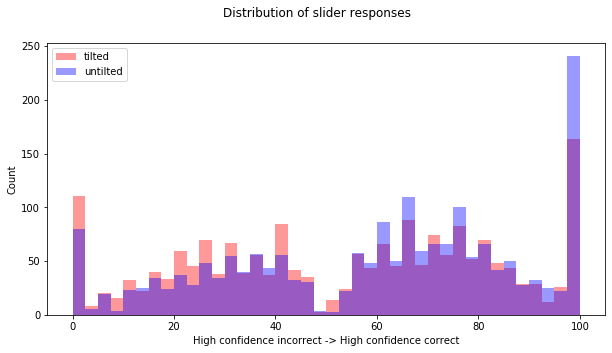

In [2265]:
fun.slider_response_plot(df)

retrieval accuracy black vs. white

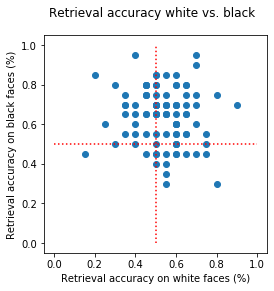

In [2266]:
fun.retrieval_race_scatter_plot(stats)

In [2267]:
stats.ret_acc_delta.mean()
# acc(white) - acc(black)

-0.10714285714285714

In [2268]:
# ORE
print(sp.ttest_ind(stats.ret_acc_b, stats.ret_acc_w))

Ttest_indResult(statistic=5.534897368082118, pvalue=1.0011378044448609e-07)


Retrieval performance predicted by encoding performance

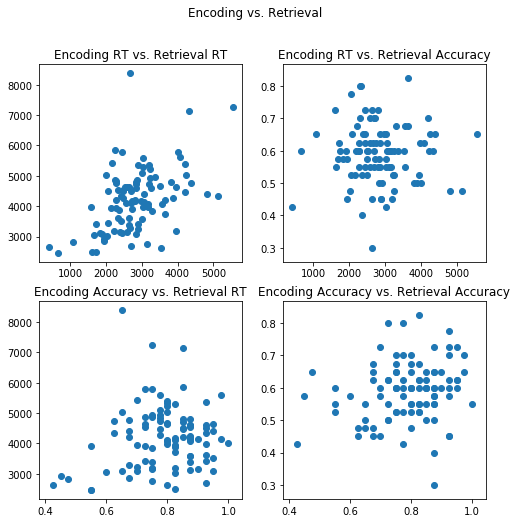

In [2269]:
fun.encoding_retrieval_plot(stats)

In [2270]:
print(sp.linregress(x=stats.enc_rt, y=stats.ret_rt))
print(sp.linregress(x=stats.enc_rt, y=stats.ret_acc))
print(sp.linregress(x=stats.enc_acc, y=stats.ret_rt))
print(sp.linregress(x=stats.enc_acc, y=stats.ret_acc))

LinregressResult(slope=0.5845857352315685, intercept=2574.3042457246447, rvalue=0.48133514136108096, pvalue=5.242170044775235e-07, stderr=0.10865134383080713)
LinregressResult(slope=-1.9563701263327767e-06, intercept=0.5953226340297961, rvalue=-0.01842334928344811, pvalue=0.8571077784690562, stderr=1.0836102479118135e-05)
LinregressResult(slope=1369.957474417577, intercept=3144.8116152238053, rvalue=0.15333485404030814, pvalue=0.13171047723620705, stderr=901.0816276124514)
LinregressResult(slope=0.15565323777884166, intercept=0.4669807488648067, rvalue=0.19925542939776822, pvalue=0.04918423933680807, stderr=0.07812953262828634)


Retrieval accuracy by tilt shown at encoding

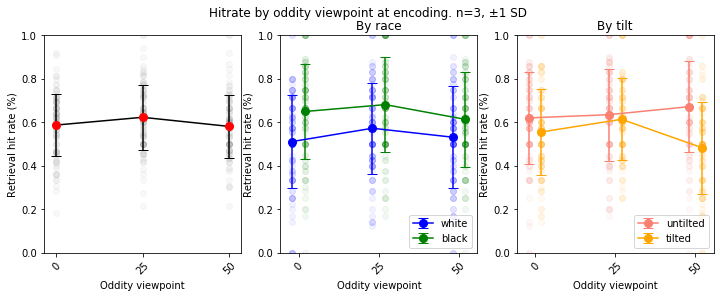

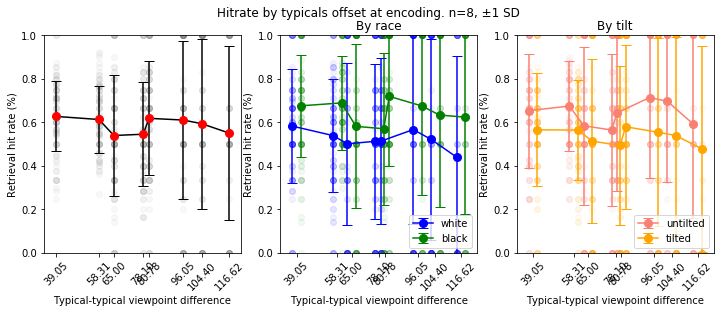

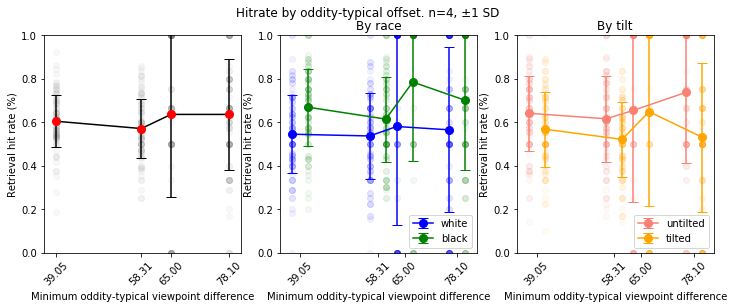

In [2271]:
# 3 measures of encoding tilt on retrieval performance:
# 1. Oddity viewpoint (symmetrical)
# 2. Typical-typical offset
# 3. Oddity-typical offset (min)

fun.encoding_tilt_plots(df)

In [2383]:
fun.show_model_parameters(smf.ols("accuracy ~ enc_tilt * ret_tilt", data = {
        'accuracy': np.concatenate([stats.ret_acc_0_enc_00C, 
                                    np.nanmean([stats.ret_acc_0_enc_25R, stats.ret_acc_0_enc_25L],axis=0), 
                                    np.nanmean([stats.ret_acc_0_enc_50R, stats.ret_acc_0_enc_50L],axis=0),
                                    stats.ret_acc_50_enc_00C, 
                                    np.nanmean([stats.ret_acc_50_enc_25R, stats.ret_acc_50_enc_25L],axis=0), 
                                    np.nanmean([stats.ret_acc_50_enc_50R, stats.ret_acc_50_enc_50L],axis=0),
                                    ]), 
    
        'ret_tilt': np.concatenate([np.repeat(0, 3*len(stats)), np.repeat(1, 3*len(stats))]),
        'enc_tilt': np.concatenate([np.repeat(0, len(stats)), np.repeat(1, len(stats)), np.repeat(2, len(stats)), 
                                    np.repeat(0, len(stats)), np.repeat(1, len(stats)), np.repeat(2, len(stats))])
        }))

$\beta = -0.06$, $F(3, 584)$ = $-2.76, P = 0.006 $

Confidence by tilt for hit trials

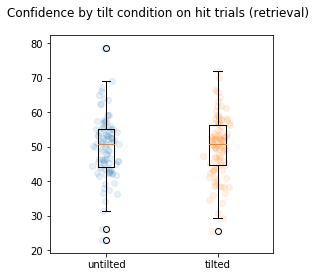

In [2272]:
fun.hits_confidence_by_tilt_plot(df)

### KEY RETRIEVAL ANALYSES


**1. Retrieval bias predicted by encoding bias**

In [2273]:
ids = stats[pd.isna(stats.ret_dist)].experiment_id
df[df.experiment_id.isin(ids)].iteration.unique()

array([], dtype=object)

In [2274]:
# test = df[df.iteration == 'pilot_prolific_afc']
# test = test[test.trial_type.str.contains('retrieval')]
len(test.experiment_id.unique())

8

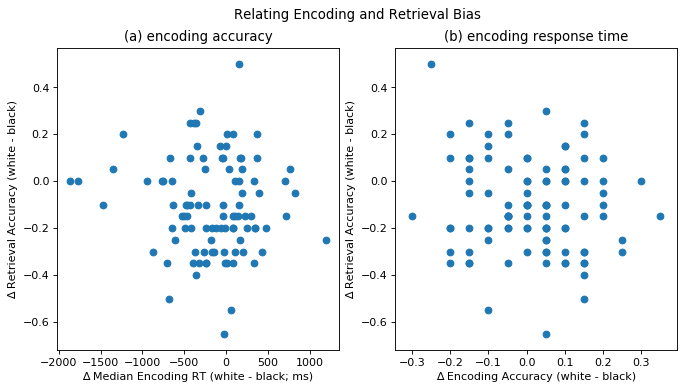

In [2308]:
fun.encoding_delta_plot(stats, save=True, slider=False)
# fun.encoding_delta_plot(stats, slider=True)

In [2276]:
print(sp.linregress(x=stats.enc_rt_delta, y=stats.ret_acc_delta))
print(sp.linregress(x=stats.enc_acc_delta, y=stats.ret_acc_delta))
print(sp.linregress(x=stats.enc_rt_delta, y=stats.ret_dist_delta))
print(sp.linregress(x=stats.enc_acc_delta, y=stats.ret_dist_delta))

LinregressResult(slope=-2.8413470268925286e-05, intercept=-0.11173337219150911, rvalue=-0.07193078148603511, pvalue=0.48152337003885737, stderr=4.0211237580054044e-05)
LinregressResult(slope=-0.18476369404191756, intercept=-0.10478617737191431, rvalue=-0.12033977482211201, pvalue=0.23787580915452777, stderr=0.15556223733804805)
LinregressResult(slope=0.004758545024844801, intercept=7.307869709641452, rvalue=0.18948356980706751, pvalue=0.06166580148963032, stderr=0.0025166750498115727)
LinregressResult(slope=2.486115067606556, intercept=6.507362697265168, rvalue=0.025469514083523444, pvalue=0.8034066845935194, stderr=9.959190541633982)


In [2277]:
smf.mixedlm("ret_acc_delta ~ enc_rt_delta", data = {
    "ret_acc_delta": stats.ret_acc_delta,
    "enc_rt_delta": stats.enc_rt_delta
    }, groups = stats['experiment_id'],
            #re_formula = "~enc_rt_delta"
           ).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: ret_acc_delta
No. Observations: 98      Method:             REML         
No. Groups:       98      Scale:              0.0202       
Min. group size:  1       Likelihood:         6.9210       
Max. group size:  1       Converged:          Yes          
Mean group size:  1.0                                      
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept       -0.112    0.004 -26.736 0.000 -0.120 -0.104
enc_rt_delta    -0.000    0.000  -0.808 0.419 -0.000  0.000
Group Var        0.020                                     
===========================================================

"""

are residuals greater than 0? of course they are

**2. Retrieval accuracy by tilt and race**

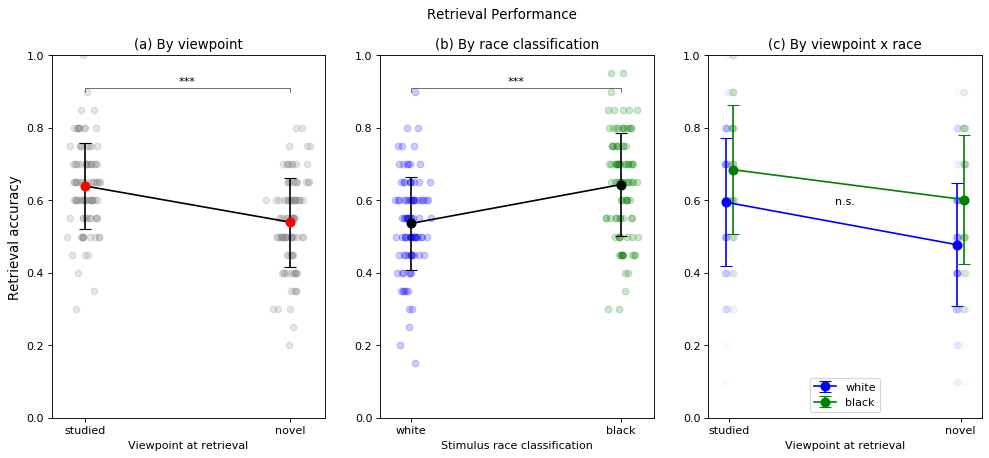

In [2307]:
fun.retrieval_plots(stats, save=True)

In [2279]:
print(sp.ttest_ind(stats.ret_acc_0, stats.ret_acc_50))
print(sp.ttest_ind(stats.ret_acc_w, stats.ret_acc_b))

Ttest_indResult(statistic=5.827087583100377, pvalue=2.3147756242518283e-08)
Ttest_indResult(statistic=-5.534897368082118, pvalue=1.0011378044448609e-07)


In [2280]:
# interaction
fun.show_model_parameters(smf.ols("accuracy ~ tilt * race", data = {
    'accuracy': np.concatenate([stats.ret_acc_w_0, stats.ret_acc_b_0, 
                                stats.ret_acc_w_50, stats.ret_acc_b_50]), 
    'tilt': np.concatenate([np.repeat(0, 2*len(stats)), np.repeat(1, 2*len(stats))]),
    'race': np.concatenate([np.repeat(1, len(stats)), np.repeat(0, len(stats)), 
                            np.repeat(1, len(stats)), np.repeat(0, len(stats))])
    }))

$\beta = -0.03$, $F(3, 388)$ = $-0.98, P = 0.328 $

In [2281]:
# interaction
fun.show_model_parameters(smf.ols("accuracy ~ tilt*race", data = {
    'accuracy': np.concatenate([stats.ret_acc_w_0, stats.ret_acc_b_0, 
                                stats.ret_acc_w_50, stats.ret_acc_b_50]), 
    'tilt': np.concatenate([np.repeat(0, 2*len(stats)), np.repeat(1, 2*len(stats))]),
    'race': np.concatenate([np.repeat(1, len(stats)), np.repeat(0, len(stats)), 
                            np.repeat(1, len(stats)), np.repeat(0, len(stats))])
    }))

$\beta = -0.03$, $F(3, 388)$ = $-0.98, P = 0.328 $

## Item-Level Analysis

We can obtain for each face 1) avg encoding accuracy (when this face is oddity), 2) avg encoding RT, and 3) avg retrieval accuracy, and relate these measures to each other, to the classification judgements, and to stimulus attributes

In [2282]:
stats_byface = fun.get_stats_byface(df)

Encoding

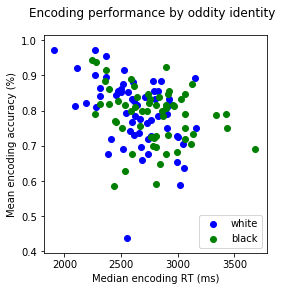

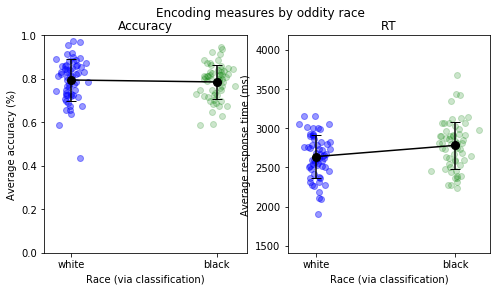

In [2283]:
fun.encoding_byface_plot(stats_byface)
fun.encoding_byface_group_plot(stats_byface)

In [2284]:
print(sp.ttest_ind(stats_byface[stats_byface.race == 'white'].enc_acc, 
                   stats_byface[stats_byface.race == 'black'].enc_acc))
print(sp.ttest_ind(stats_byface[stats_byface.race == 'white'].enc_rt, 
                   stats_byface[stats_byface.race == 'black'].enc_rt))

Ttest_indResult(statistic=0.5516844484269264, pvalue=0.5822078271940738)
Ttest_indResult(statistic=-2.6949260433951387, pvalue=0.008068337516438803)


Retrieval

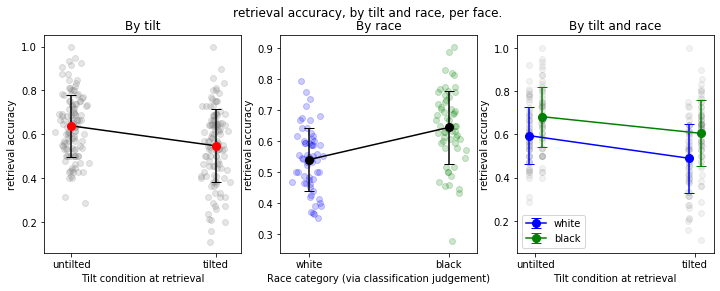

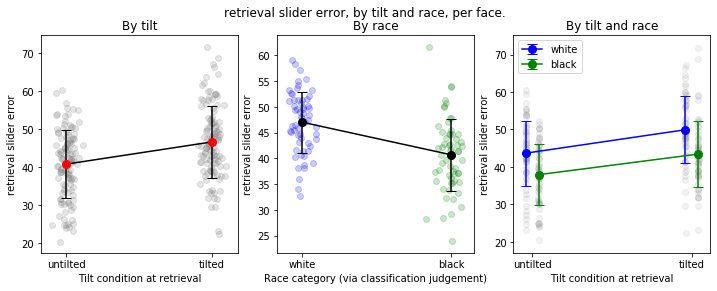

In [2285]:
fun.retrieval_byface_plots(stats_byface)
fun.retrieval_byface_plots(stats_byface, slider=True)

In [2286]:
print(sp.ttest_ind(stats_byface.ret_acc_0, 
                   stats_byface.ret_acc_50))
print(sp.ttest_ind(stats_byface[stats_byface.race == 'white'].ret_acc, 
                   stats_byface[stats_byface.race == 'black'].ret_acc))
# interaction
w = stats_byface[stats_byface.race=='white']
b = stats_byface[stats_byface.race=='black']
fun.show_model_parameters(smf.ols("accuracy ~ tilt * race", data = {
    'accuracy': np.concatenate([w.ret_acc_0, b.ret_acc_0, w.ret_acc_50,b.ret_acc_50]),
    'tilt': np.concatenate([np.repeat(0, len(stats_byface)), np.repeat(1, len(stats_byface))]),
    'race': np.concatenate([np.repeat(1, len(w)), np.repeat(0, len(b)), 
                            np.repeat(1, len(w)), np.repeat(0, len(b))])
    }))

Ttest_indResult(statistic=4.554073814312454, pvalue=8.403485727634545e-06)
Ttest_indResult(statistic=-5.138912805775014, pvalue=1.1070743320438011e-06)


$\beta = -0.03$, $F(3, 236)$ = $-0.71, P = 0.476 $

Encoding vs. retrieval

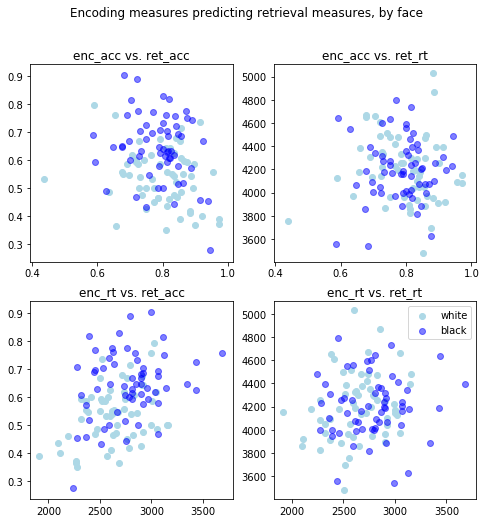

In [2287]:
fun.encoding_retrieval_byface_plot(stats_byface)
#fun.encoding_retrieval_byface_plot(mb_resid)

In [2288]:
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.enc_acc))
print(sp.linregress(x=stats_byface.enc_acc, y=stats_byface.ret_acc))
print(sp.linregress(x=stats_byface.enc_acc, y=stats_byface.ret_rt))
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.ret_acc))
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.ret_rt))

LinregressResult(slope=-9.952421198662138e-05, intercept=1.059847161993022, rvalue=-0.33297193853669504, pvalue=0.0002024312495134442, stderr=2.5945537084747976e-05)
LinregressResult(slope=-0.31710790004368483, intercept=0.8426735759104935, rvalue=-0.2301383781575837, pvalue=0.011448892098803122, stderr=0.12344125513126629)
LinregressResult(slope=-68.27741331308437, intercept=4256.070946353392, rvalue=-0.021849046929449077, pvalue=0.8127596690855463, stderr=287.6072779166945)
LinregressResult(slope=0.00015648319833081156, intercept=0.1681751750131914, rvalue=0.3799518710207334, pvalue=1.8668241952481028e-05, stderr=3.507056748539986e-05)
LinregressResult(slope=0.12207702201718933, intercept=3871.4133418912406, rvalue=0.13069779219279493, pvalue=0.15478026890554092, stderr=0.0852478304079287)


In [2289]:
# interaction between enc_acc and race on ret_acc
w = stats_byface[stats_byface.race=='white']
b = stats_byface[stats_byface.race=='black']
fun.show_model_parameters(smf.ols("ret_acc ~ enc_rt * race", data = {
    'ret_acc': np.concatenate([w.ret_acc, b.ret_acc]),
    'enc_rt': np.concatenate([w.enc_rt, b.enc_rt]),
    'race': np.concatenate([np.repeat(1, len(w)), np.repeat(0, len(b))])
    }))

$\beta = 0.00$, $F(3, 116)$ = $0.52, P = 0.601 $

Stimulus attributes

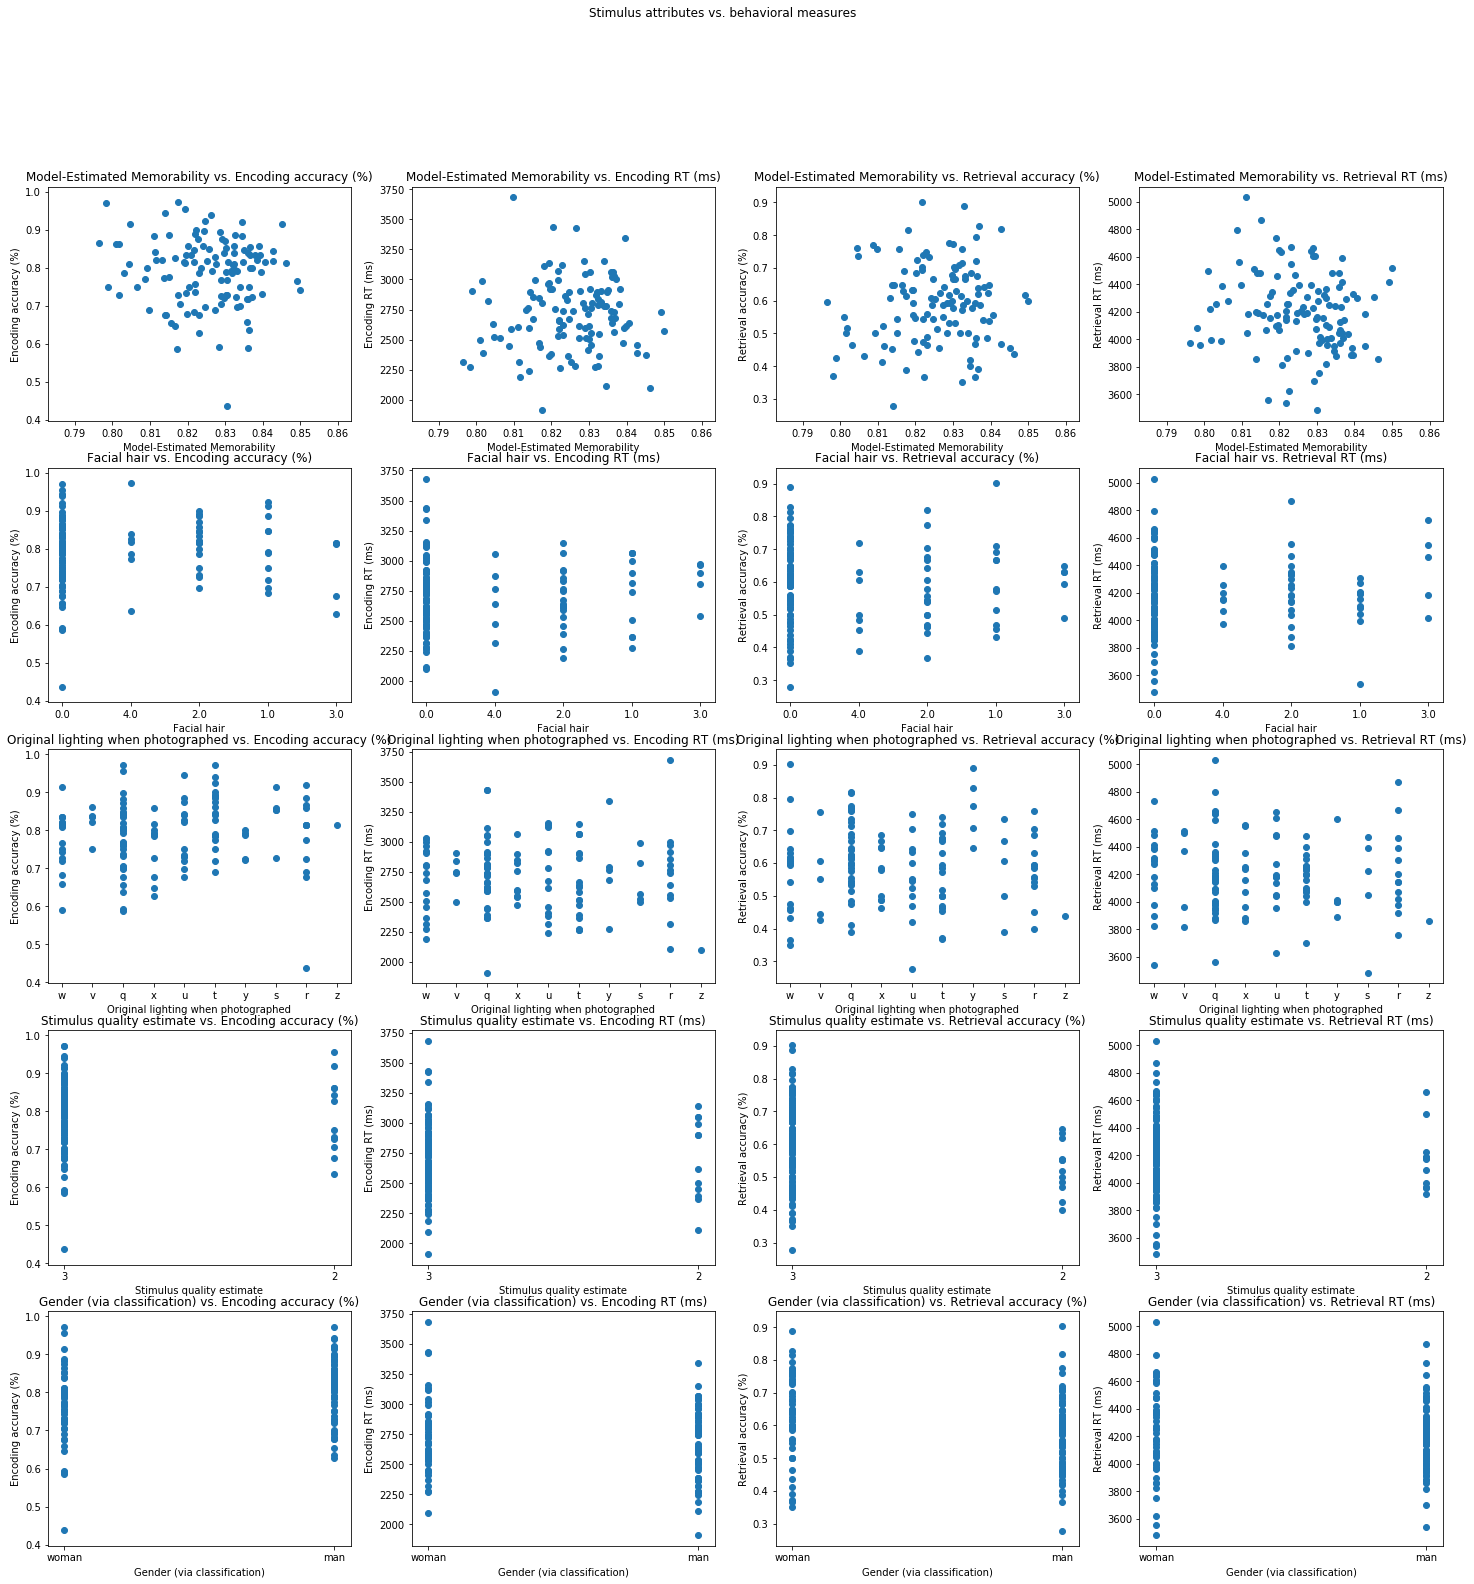

In [2290]:
fun.stim_attributes_plot(stats_byface, meta)

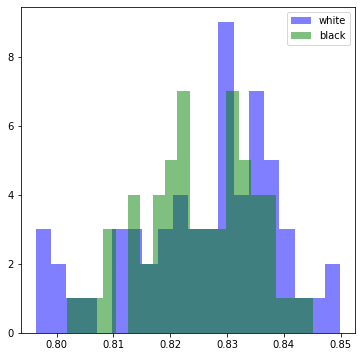

In [2291]:
# memorability scores as a function of race
fun.mb_race_plot(meta)

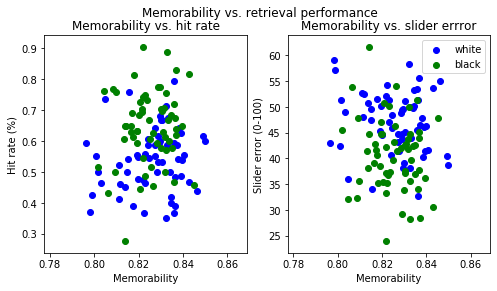

In [2292]:
# memorability by race and retrieval accuracy 
# add per image memorability
fun.mb_race_acc_plot(stats_byface, meta)

## Next steps

1. Analyze slider responses instead of correct/incorrect retrieval accuracy *DONE* (separate notebook)

2. Median split half by encoding deltas (vs. random pairing)? *BELOW*

3. Predict residuals of memorability *BELOW*

### Median split half by encoding RT data, instead of race

In [2293]:
stats_enc_split = fun.get_encoding_split_stats(df, only_correct_encoding = True)


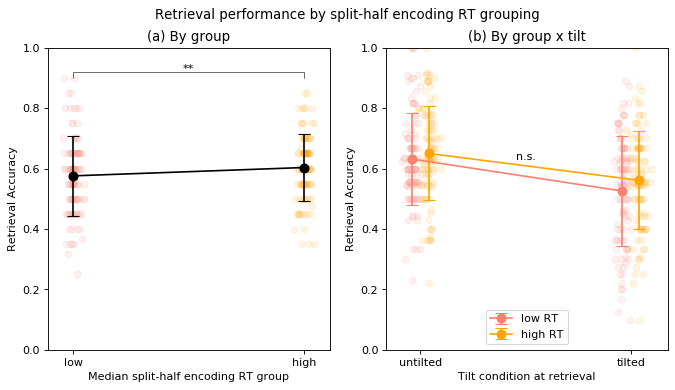

Test for panel A: 
 WilcoxonResult(statistic=1462.0, pvalue=0.10814955196396202)
Test for panel B: 
 $\beta = 0.02$, $F(3, 388)$ = $0.51, P = 0.610 $


In [2294]:
fun.retrieval_split_plot(stats_enc_split, slider = False, save=False)

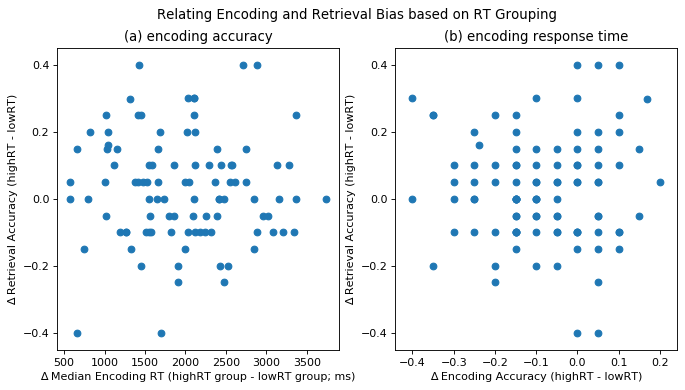

In [2295]:
fun.encoding_split_delta_plot(stats_enc_split, slider=False, save=False)

In [2296]:
print(sp.linregress(x=stats_enc_split.enc_rt_delta, y=stats_enc_split.ret_acc_delta))
print(sp.linregress(x=stats_enc_split.enc_acc_delta, y=stats_enc_split.ret_acc_delta))
print(sp.linregress(x=stats_enc_split.enc_rt_delta, y=stats_enc_split.ret_dist_delta))
print(sp.linregress(x=stats_enc_split.enc_acc_delta, y=stats_enc_split.ret_dist_delta))

LinregressResult(slope=-4.216012237528687e-06, intercept=0.03596085689453501, rvalue=-0.019430243692820048, pvalue=0.8493878429845372, stderr=2.2141447153425917e-05)
LinregressResult(slope=0.00404677771504199, intercept=0.027986950967989883, rvalue=0.003423753692376758, pvalue=0.9733088377072077, stderr=0.12063370714498733)
LinregressResult(slope=0.001107594927479734, intercept=-4.142267742394098, rvalue=0.08184522482471757, pvalue=0.4230297127523527, stderr=0.0013765516471822754)
LinregressResult(slope=-2.763751796427147, intercept=-2.1935481585447163, rvalue=-0.03749110190077467, pvalue=0.7139846338801688, stderr=7.518475403562877)


### Predicting residuals of memorability

In [2297]:
mb_resid = stats_byface.copy()
print('R-squared values')
for col in mb_resid.columns:
    if col not in ['identity', 'race', 'gender']: 
        model = smf.ols("target ~ enc_rt", data = {
            "target": stats_byface[col],
            "enc_rt": stats_byface['enc_rt']
        }).fit()
        mb_resid[col] = model.resid
        print(col + ": " + str(model.rsquared))


R-squared values
enc_rt: 1.0
enc_acc: 0.11087031185288454
ret_rt: 0.01708191288407046
ret_acc: 0.14436342429215576
ret_rt_0: 0.0034657815224981015
ret_acc_0: 0.05104298393520956
ret_rt_50: 0.004334417642721244
ret_acc_50: 0.11048853961003102
ret_dist: 0.10482197828276008
ret_dist_0: 0.029521689982558885
ret_dist_50: 0.08931717098850733
mb: 0.004626217071306837


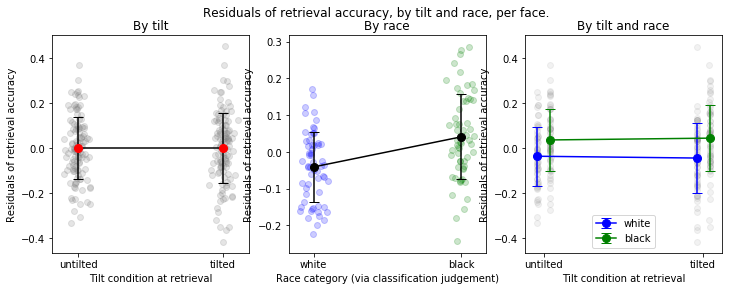

In [2298]:
# ignore all but middle plot I think
fun.retrieval_byface_plots(mb_resid, slider = False, mb=True)

In [2299]:
fun.ret_tests_byface(mb_resid)

Ttest_indResult(statistic=-4.699815832414717e-15, pvalue=0.9999999999999962)
Ttest_indResult(statistic=-4.23723875704589, pvalue=4.511866825653315e-05)
$\beta = -0.02$, $F(3, 236)$ = $-0.43, P = 0.666 $


In [2300]:
enc_mb_resid = stats_byface.copy()
for col in enc_mb_resid.columns:
    if col not in ['identity', 'race', 'gender']: 
        model = smf.ols("target ~ enc_rt * enc_acc * mb", data = {
            "target": stats_byface[col],
            "enc_rt": stats_byface['enc_rt'],
            "enc_acc": stats_byface['enc_acc'],
            "mb": stats_byface['mb']
        }).fit()
        enc_mb_resid[col] = model.resid
        # print(col + ": " + str(model.rsquared))

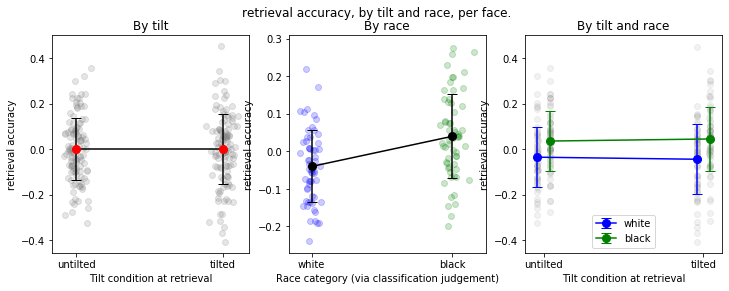

In [2301]:
fun.retrieval_byface_plots(enc_mb_resid, slider = False)

In [2302]:
fun.ret_tests_byface(enc_mb_resid)

Ttest_indResult(statistic=1.600959677682095e-11, pvalue=0.9999999999872395)
Ttest_indResult(statistic=-4.225195133810046, pvalue=4.726464672959002e-05)
$\beta = -0.02$, $F(3, 236)$ = $-0.50, P = 0.617 $


### Just white participants

In [2303]:
stats_w = fun.get_stats(df_white)
stats_byface_w = fun.get_stats_byface(df_white)

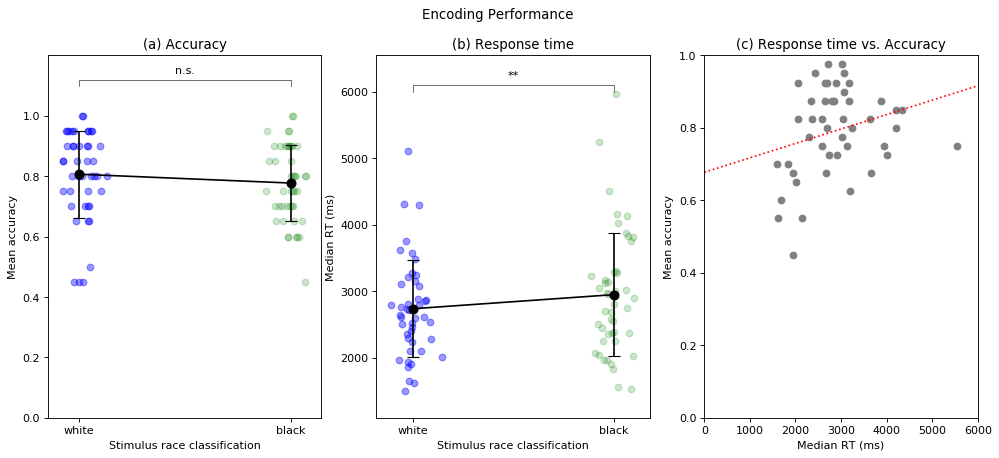

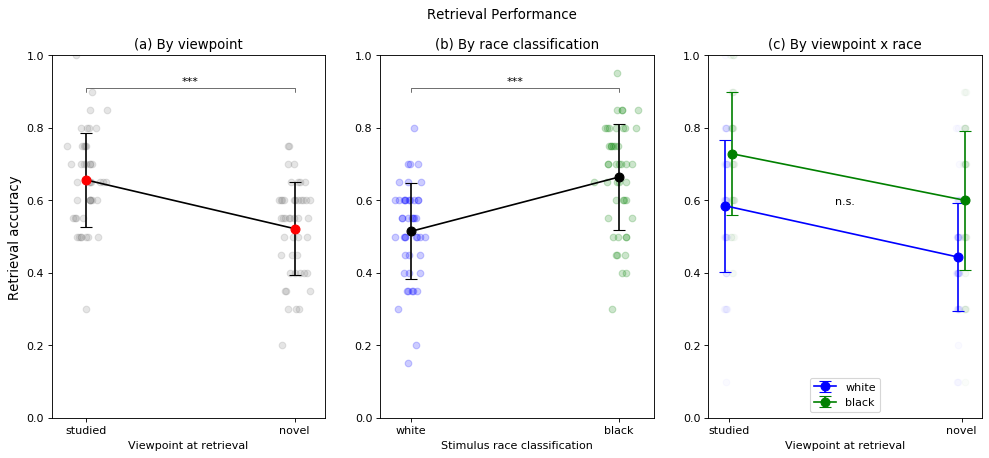

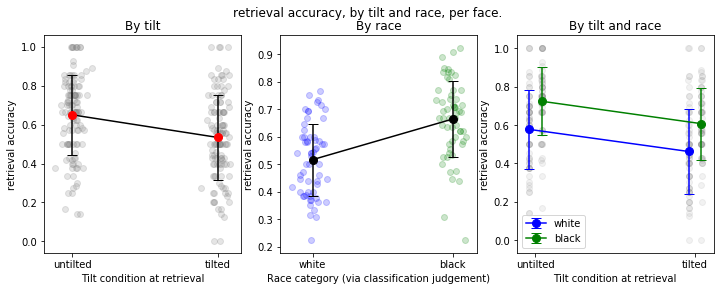

In [2382]:
fun.encoding_plot(stats_w)
fun.retrieval_plots(stats_w, slider = False)
fun.retrieval_byface_plots(stats_byface_w, slider = False)

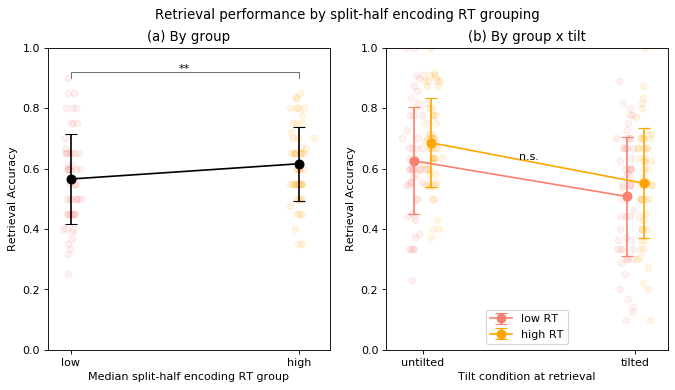

Test for panel A: 
 WilcoxonResult(statistic=392.0, pvalue=0.04398226697335837)
Test for panel B: 
 $\beta = -0.02$, $F(3, 216)$ = $-0.34, P = 0.733 $


In [2381]:
stats_enc_split2 = fun.get_encoding_split_stats(df_white)
fun.retrieval_split_plot(stats_enc_split2, slider = False, save=True)

### Split half reliability analyses

In [ ]:
# of faces, of images, of races, of race-by-tilt (all resolutions)